In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dữ liệu
flight_data = pd.read_csv("flights_sample_3m.csv")

In [3]:
flight_data.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [4]:
flight_data.shape

(3000000, 32)

## Tách dữ liệu chỉ riêng năm 2023

In [5]:
# Lọc dữ liệu năm 2023
flight_data_2023 = flight_data[flight_data['FL_DATE'].str.startswith('2023')]

In [6]:
flight_data_2023.to_csv(r'C:\pycharm\Flight-delay-forecast-master\flight_data_2023.csv', index=False)

In [7]:
flight_data_2023.shape

(463484, 32)

In [37]:
# Loại bỏ các cột không cần thiết
flight_data_2023 = flight_data_2023.drop(columns=['AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'ORIGIN_CITY', 'DEST_CITY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'FL_DATE'])
flight_data_2023 = flight_data_2023.dropna()

In [38]:
# One-hot encoding
categorical_features = ['AIRLINE', 'ORIGIN', 'DEST']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = pd.DataFrame(encoder.fit_transform(flight_data_2023[categorical_features]))
encoded_features.columns = encoder.get_feature_names_out(categorical_features)
encoded_features.index = flight_data_2023.index

In [39]:
# Kết hợp dữ liệu đã mã hóa với các cột khác
data = flight_data_2023.drop(columns=categorical_features)
data = pd.concat([data, encoded_features], axis=1)

In [40]:
# Chuyển tất cả các cột dữ liệu sang kiểu float
data = data.astype(float)

In [41]:
# Chuẩn hóa các cột số
numeric_features = ['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
                    'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
                    'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                    'DELAY_DUE_LATE_AIRCRAFT']
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [42]:
# Tách dữ liệu thành tập huấn luyện và kiểm tra
X = data.drop(columns=['ARR_DELAY'])
y = data['ARR_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Xây dựng mô hình ANN
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [43]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
2094/2094 [==============================] - 4s 2ms/step - loss: 4759.2754 - val_loss: 1148.4391
Epoch 2/20
2094/2094 [==============================] - 3s 1ms/step - loss: 107.0954 - val_loss: 20.3146
Epoch 3/20
2094/2094 [==============================] - 3s 1ms/step - loss: 75.4161 - val_loss: 68.1885
Epoch 4/20
2094/2094 [==============================] - 3s 2ms/step - loss: 55.8969 - val_loss: 32.9734
Epoch 5/20
2094/2094 [==============================] - 3s 2ms/step - loss: 32.8796 - val_loss: 16.7143
Epoch 6/20
2094/2094 [==============================] - 3s 1ms/step - loss: 36.3645 - val_loss: 21.5972
Epoch 7/20
2094/2094 [==============================] - 3s 1ms/step - loss: 26.8267 - val_loss: 20.2322
Epoch 8/20
2094/2094 [==============================] - 3s 2ms/step - loss: 37.5700 - val_loss: 3.4890
Epoch 9/20
2094/2094 [==============================] - 3s 1ms/step - loss: 18.3624 - val_loss: 18.0357
Epoch 10/20
2094/2094 [==============================] - 4s 

In [44]:
# Lưu mô hình và các đối tượng encoder, scaler
model.save('flight_delay_model.h5')
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Lưu tên các cột trong X_train
X_train_columns = X_train.columns.tolist()
with open('X_train_columns.pkl', 'wb') as f:
    pickle.dump(X_train_columns, f)

print("Model training and saving completed.")

Model training and saving completed.


In [45]:
# Đánh giá mô hình
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

655/655 [==============================] - 1s 1ms/step
MSE: 28.715972254830326
MAE: 4.371414477297118


In [46]:
# Số lượng loại hãng hàng không
num_unique_airlines = flight_data_2023['AIRLINE'].nunique()

# Số lượng loại điểm xuất phát
num_unique_origins = flight_data_2023['ORIGIN'].nunique()

# Số lượng loại điểm đến
num_unique_destinations = flight_data_2023['DEST'].nunique()

print("Số lượng loại hãng hàng không:", num_unique_airlines)
print("Số lượng loại điểm xuất phát:", num_unique_origins)
print("Số lượng loại điểm đến:", num_unique_destinations)


Số lượng loại hãng hàng không: 15
Số lượng loại điểm xuất phát: 343
Số lượng loại điểm đến: 343


In [47]:
# Hiển thị tất cả các loại hãng hàng không
unique_airlines = flight_data_2023['AIRLINE'].unique()
print("Các loại hãng hàng không:", unique_airlines)

# Hiển thị tất cả các loại điểm xuất phát
unique_origins = flight_data_2023['ORIGIN'].unique()
print("Các loại điểm xuất phát:", unique_origins)

# Hiển thị tất cả các loại điểm đến
unique_destinations = flight_data_2023['DEST'].unique()
print("Các loại điểm đến:", unique_destinations)


Các loại hãng hàng không: ['Delta Air Lines Inc.' 'Republic Airline' 'Spirit Air Lines'
 'United Air Lines Inc.' 'American Airlines Inc.' 'JetBlue Airways'
 'Hawaiian Airlines Inc.' 'Alaska Airlines Inc.' 'Frontier Airlines Inc.'
 'SkyWest Airlines Inc.' 'Envoy Air' 'Southwest Airlines Co.'
 'Allegiant Air' 'Endeavor Air Inc.' 'PSA Airlines Inc.']
Các loại điểm xuất phát: ['MSP' 'DFW' 'EWR' 'SFO' 'JFK' 'MCO' 'MIA' 'TPA' 'BOS' 'DCA' 'SJC' 'SEA'
 'STL' 'MSY' 'MCI' 'SJU' 'ORD' 'DEN' 'TUS' 'LAS' 'MKE' 'PGD' 'FLL' 'LGA'
 'BNA' 'MDW' 'AUS' 'IAH' 'MYR' 'DAL' 'ATL' 'CMH' 'CLT' 'CVG' 'SAN' 'PHX'
 'OAK' 'DTW' 'SCE' 'BDL' 'RDU' 'BWI' 'MSO' 'ATW' 'COS' 'SDF' 'PHL' 'LEX'
 'ROC' 'SNA' 'BUR' 'SLC' 'OGG' 'SAV' 'HOU' 'JAX' 'MHT' 'IAD' 'BHM' 'HPN'
 'BIL' 'LAX' 'MDT' 'TLH' 'ACY' 'PIT' 'STT' 'ECP' 'GSP' 'PNS' 'OMA' 'SMF'
 'FAR' 'CID' 'ELP' 'PBI' 'MFR' 'RIC' 'MAF' 'PDX' 'BLI' 'MEM' 'GRR' 'IND'
 'OKC' 'HSV' 'RNO' 'SBN' 'SFB' 'CHS' 'RSW' 'SAF' 'PAE' 'TYS' 'JAN' 'ISP'
 'HNL' 'PSG' 'HYS' 'SAT' 'CAE' 'EUG' 'ONT

In [48]:
# Tải mô hình và các đối tượng encoder, scaler, và tên các cột
model = load_model('flight_delay_model.h5')
with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('X_train_columns.pkl', 'rb') as f:
    X_train_columns = pickle.load(f)

# Định nghĩa lại categorical_features và numeric_features
categorical_features = ['AIRLINE', 'ORIGIN', 'DEST']
numeric_features = ['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
                    'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
                    'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                    'DELAY_DUE_LATE_AIRCRAFT']

# Tạo một số dữ liệu mới cho dữ liệu test
test_data_new = pd.DataFrame({
    'AIRLINE': ['Delta Air Lines Inc.', 'American Airlines Inc.'],
    'ORIGIN': ['MSP', 'LAX'],
    'DEST': ['SFO', 'JFK'],
    'CRS_DEP_TIME': [12.0, 15.0],
    'DISTANCE': [1500, 2500],
    'CRS_ELAPSED_TIME': [240, 300],
    'DEP_TIME': [10, 13],
    'DEP_DELAY': [2, 3],
    'TAXI_OUT': [20, 25],
    'WHEELS_OFF': [30, 38],
    'WHEELS_ON': [45, 50],
    'TAXI_IN': [8, 10],
    'CRS_ARR_TIME': [50, 55],
    'ARR_TIME': [53, 58],
    'ELAPSED_TIME': [263, 305],
    'AIR_TIME': [235, 280],
    'DELAY_DUE_CARRIER': [5, 7],
    'DELAY_DUE_WEATHER': [0, 0],
    'DELAY_DUE_NAS': [0, 0],
    'DELAY_DUE_SECURITY': [0, 0],
    'DELAY_DUE_LATE_AIRCRAFT': [0, 0]
})

In [49]:
# Thêm cột 'FL_NUMBER' với giá trị mặc định 0 (hoặc giá trị phù hợp)
test_data_new['FL_NUMBER'] = 0

# Áp dụng mã hóa one-hot cho dữ liệu thử nghiệm mới
test_encoded_features = pd.DataFrame(encoder.transform(test_data_new[categorical_features]))
test_encoded_features.columns = encoder.get_feature_names_out(categorical_features)

# Kết hợp dữ liệu thử nghiệm mới với các cột số đã chuẩn hóa
test_data_new = test_data_new.drop(columns=categorical_features)
test_data_new = pd.concat([test_data_new, test_encoded_features], axis=1)

# Chuẩn hóa các đặc trưng số trong dữ liệu thử nghiệm mới
test_data_new[numeric_features] = scaler.transform(test_data_new[numeric_features])

# Đảm bảo dữ liệu thử nghiệm mới có cùng các đặc trưng và thứ tự với X_train
test_data_new = test_data_new[X_train_columns]

In [50]:

# Dự đoán độ trễ của chuyến bay với mô hình đã huấn luyện
predicted_delay_new = model.predict(test_data_new)

# In kết quả dự đoán
print("Dự đoán độ trễ của các chuyến bay mới:")
for i in range(len(predicted_delay_new)):
    print(f"Chuyến bay {i+1}: {predicted_delay_new[i][0]} phút")

1/1 [==============================] - 0s 74ms/step
Dự đoán độ trễ của các chuyến bay mới:
Chuyến bay 1: 14.871678352355957 phút
Chuyến bay 2: 11.6683931350708 phút


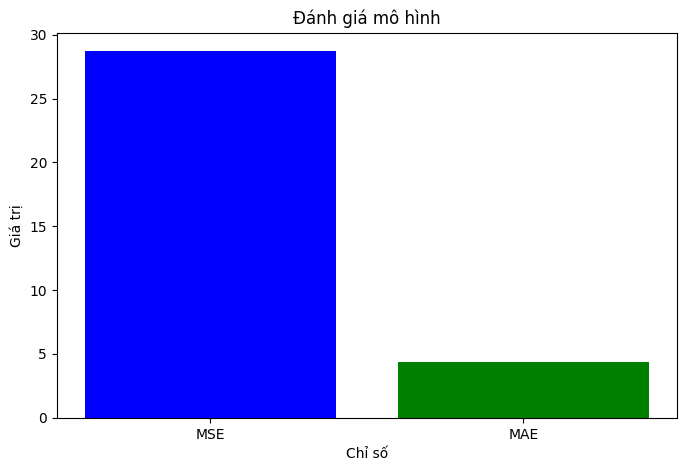

In [51]:
# Danh sách các chỉ số đánh giá
metrics = ['MSE', 'MAE']

# Giá trị của các chỉ số tương ứng
values = [mse, mae]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Đánh giá mô hình')
plt.xlabel('Chỉ số')
plt.ylabel('Giá trị')
plt.show()